<a href="https://colab.research.google.com/github/CorsiDanilo/big-data-computing-project/blob/main/1_BDC_Project_Bitcoin_price_forecasting_(Data_cleaning_%2B_exploration_%2B_selection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin price forecasting with PySpark
## Big Data Computing final project - A.Y. 2022 - 2023
Prof. Gabriele Tolomei

MSc in Computer Science

La Sapienza, University of Rome

### Author
Corsi Danilo - corsi.1742375@studenti.uniroma1.it



### Introduction

The cryptocurrency Bitcoin has attracted the attention of many people in recent years. However, it's
price fluctuation can be extremely unpredictable, which makes it difficult to predict when the right
time to buy or sell this digital currency will be. In this context, forecasting Bitcoin prices can be a
competitive advantage for investors and traders, as it could allow them to make informed decisions
on the right time to enter or exit the market. In this project, I will analyze some machine learning
techniques to understand, through the processing of historical data, how accurately the price of Bitcoin
can be predicted and whether this can provide added value to cryptocurrency investors and traders.
### Dataset
I chose to use the following dataset from Kaggle Bitcoin Historical Dataset, more specifically those
containing minute-by-minute updates of the Bitcoin price from 2017 to 2021 (period for which there
were moments of high volatility but also a lot of price lateralisation). The columns (features) contained
in it, in addition to the timestamp of each transaction, are the opening, closing, highest and lowest
price and the corresponding trading volume in Bitcoin and Dollars.
### Methods (TODO: da scegliere per bene)
The methods I will test will be Linear Regression (simple and multiple) and Random Forest. Further
comparisons with other classification models are planned in the course of development. Moreover, I
would also like to try to understand what the differences are between these methods and the imple-
mentation of a state-of-the-art neural network such as Long-Short Term Memory.
### Evaluation framework (TODO: vedi quali usare in base ai paper/esempi e ai modelli utilizzati)
As evaluation framework I will use R-square (R²), Mean Square Error (MSE) and Mean Absolute
Error (MAE) to get a complete picture of the performance of the various models.

# Global Constants


In [29]:
# TODO: da sistemare

JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/drive"
GDRIVE_DATASET_DIR = GDRIVE_DIR + "/MyDrive/Computer_Science/BDC/project/datasets/raw"
GDRIVE_DATASET_TEMP_DIR = GDRIVE_DIR + "/MyDrive/Computer_Science/BDC/project/datasets/temp"
GDRIVE_DATASET_OUTPUT_DIR = GDRIVE_DIR + "/MyDrive/Computer_Science/BDC/project/datasets/output"

GDRIVE_DATASET_NAME = "data"
GDRIVE_DATASET_NAME_EXT = "/" + GDRIVE_DATASET_NAME + ".csv"

GDRIVE_DATASET = GDRIVE_DATASET_DIR + GDRIVE_DATASET_NAME_EXT

SLOW_OPERATION = False

#  Import useful Python packages

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from itertools import cycle

import plotly.express as px

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import gc

# **Spark + Google Colab Setup**

## Install PySpark and related dependencies





In [3]:
!pip install pyspark
# Alternatively, if you want to install a specific version of pyspark:
#!pip install pyspark==3.2.1
!pip install -U -q PyDrive # To use files that are stored in Google Drive directly (e.g., without downloading them from an external URL)
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.sql import functions as F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=dd441e85ffaac649ad65fe3c2ad6134e6e226261b719818a085fb5b2bfc70737
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 38 not upgraded.
Need to get 36.5 MB of archives.
After this operatio

##  Create Spark context

In [4]:
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("BitcoinPriceForecasting").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

##  Link Colab to our Google Drive

In [5]:
# Point Colaboratory to our Google Drive

from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


##  Check everything is ok

In [6]:
spark

In [7]:
sc._conf.getAll()

[('spark.app.submitTime', '1686406253005'),
 ('spark.driver.memory', '45G'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.app.name', 'BitcoinPriceForecasting'),
 ('spark.app.id', 'local-1686406256837'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-op

# **Data cleaning, exploration and feature selection**

In this section we are going to explore the dataset, to clean it from null values, and to determine which features are relevant and which are not.

##  Data cleaning

First, we import the dataset from Google Drive.

In [8]:
# load dataset into pyspark dataframe objects
df = spark.read.load(GDRIVE_DATASET, 
                         format="csv", 
                         sep=",", 
                         inferSchema="true", 
                         header="true"
                    )

Check the shape of the loaded dataset, print out the schema of the loaded dataset.

In [10]:
if SLOW_OPERATION:
  print("The shape of the dataset is {:d} rows by {:d} columns".format(df.count(), len(df.columns)))
  df.printSchema()
  df.show(5)	

The shape of the dataset is 2102436 rows by 9 columns
root
 |-- Timestamp: long (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume BTC: double (nullable = true)
 |-- Volume USD: double (nullable = true)

+-------------+-------------------+-------+--------+--------+--------+--------+----------+---------------+
|    Timestamp|               Date| Symbol|    Open|    High|     Low|   Close|Volume BTC|     Volume USD|
+-------------+-------------------+-------+--------+--------+--------+--------+----------+---------------+
|1676939580000|2023-02-21 00:33:00|BTC/USD|24859.34|24859.34|24859.34|24859.34|       0.0|            0.0|
|1676939520000|2023-02-21 00:32:00|BTC/USD|24821.96|24859.34|24821.96|24859.34|0.10309919|2562.9778179346|
|1676939460000|2023-02-21 00:31:00|BTC/USD|24818.09|24821.96|

TODO: da sistemare

The dataset contains **2675301** records of bitcoin historical data from 2017 to 2021; each record, contains the following set of **9** columns:

* Unix Timestamp - This is the unix timestamp or also known as "Epoch Time";
* Date - This timestamp is UTC Timezone;
* Symbol - The symbol for which the timeseries data refers;
* Open - This is the opening price of the time period;
* High - This is the highest price of the time period;
* Low - This is the lowest price of the time period;
* Close - This is the closing price of the time period;
* Volume (Crypto) - This is the volume in the transacted Ccy. Ie. For BTC/USDT, this is in BTC amount;
* Volume Base Ccy - This is the volume in the base/converted ccy. Ie. For BTC/USDT, this is in USDT amount;

We can delete the "symbol" and "unix" columns since we are not gonna use it and changing the name of "Volume BTC" and "Volume USD", check how many Nan values we have in the dataset and reduce the columns in the DataFrame to two decimal places except for the btc volume.


In [11]:
# TODO: da sistemare

def data_cleaning(dataframe):
  from pyspark.sql.functions import from_unixtime, to_timestamp

  # # transforming the column "time" into a date type column with the desired format
  # dataframe = dataframe.withColumn("time", (dataframe["time"] / 1000).cast("timestamp"))
  # dataframe = dataframe.withColumn("time", to_timestamp(dataframe["time"]).cast("string")) \
  #                       .withColumnRenamed("time", "date")

  # Here we can delete the "symbol" and "unix" columns since we are not gonna use it and changing the name of "Volume BTC" and "Volume USD"
  dataframe = dataframe.withColumnRenamed("Date","date") \
    .withColumnRenamed("Open","open") \
    .withColumnRenamed("Close","close") \
    .withColumnRenamed("High","high") \
    .withColumnRenamed("Low","low") \
    .withColumnRenamed("Volume BTC","volume_btc") \
    .withColumnRenamed("Volume USD","volume_usd") \
    .drop("Symbol") \
    .drop("Timestamp")

  # Here, we can check how many Nan values we have in the dataframe.
  if SLOW_OPERATION:
    for c in dataframe.columns:
      print("N. of missing values of column `{:s}` = {:d}".format(c, dataframe.where(col(c).isNull()).count()))

  # # Here we reduce the columns in the DataFrame to two decimal places except for the volume in bitcoin.
  # dataframe = dataframe.withColumn("open", round(dataframe["open"], 2)) \
  #                 .withColumn("close", round(dataframe["close"], 2)) \
  #                 .withColumn("high", round(dataframe["high"], 2)) \
  #                 .withColumn("low", round(dataframe["low"], 2)) \
  #                 .withColumn("volume_usd", round(dataframe["volume_usd"], 2)
  #               )
                  
    dataframe.show(5)	

  return dataframe

In [12]:
df = data_cleaning(df)

N. of missing values of column `date` = 0
N. of missing values of column `open` = 0
N. of missing values of column `high` = 0
N. of missing values of column `low` = 0
N. of missing values of column `close` = 0
N. of missing values of column `volume_btc` = 0
N. of missing values of column `volume_usd` = 0
+-------------------+--------+--------+--------+--------+----------+---------------+
|               date|    open|    high|     low|   close|volume_btc|     volume_usd|
+-------------------+--------+--------+--------+--------+----------+---------------+
|2023-02-21 00:33:00|24859.34|24859.34|24859.34|24859.34|       0.0|            0.0|
|2023-02-21 00:32:00|24821.96|24859.34|24821.96|24859.34|0.10309919|2562.9778179346|
|2023-02-21 00:31:00|24818.09|24821.96|24815.47|24821.96|0.09064015| 2249.866177694|
|2023-02-21 00:30:00|24812.25|24818.09|24812.25|24818.09|0.00220329|  54.6814495161|
|2023-02-21 00:29:00|24809.27|24812.25|24809.27|24812.25|0.09067547|2249.8624305075|
+-------------

##  Exploring the data
Now, before building a model to predict the Bitcoin price, let's try a have a better visualization of the data.

In [13]:
def compute_daily_df(dataframe):
  # Calculation of the average values and volume for each day
  dataframe = dataframe.withColumn("date", date_format(dataframe.date, "yyyy-MM-dd")).groupBy("date").agg(
      avg("open").alias("open"),
      avg("close").alias("close"),
      avg("high").alias("high"),
      avg("low").alias("low"),
      avg("volume_btc").alias("volume_btc"),
      avg("volume_usd").alias("volume_usd")
  ).sort("date")

  # Reduce the columns in the DataFrame to two decimal places
  dataframe = dataframe.withColumn("open", round(dataframe["open"], 2)) \
                      .withColumn("close", round(dataframe["close"], 2)) \
                      .withColumn("high", round(dataframe["high"], 2)) \
                      .withColumn("low", round(dataframe["low"], 2)) \
                      .withColumn("volume_usd", round(dataframe["volume_usd"], 2)
                      )

  if SLOW_OPERATION:
    print("The shape of the dataset is {:d} rows by {:d} columns".format(dataframe.count(), len(dataframe.columns)))
    dataframe.show(5)

  # convert the dataframe from PySpark to Pandas
  return dataframe.toPandas()

In [14]:
daily_df = compute_daily_df(df)

The shape of the dataset is 1504 rows by 7 columns
+----------+-------+-------+-------+-------+------------------+----------+
|      date|   open|  close|   high|    low|        volume_btc|volume_usd|
+----------+-------+-------+-------+-------+------------------+----------+
|2019-01-01|3699.59|3699.68|3700.55|3698.54|2.1910859856364606|   8112.18|
|2019-01-02|3821.65|3821.69| 3823.0| 3820.3|2.7256348950100726|  10416.14|
|2019-01-03|3829.26|3829.19|3829.97|3828.48| 2.820747492742641|  10805.67|
|2019-01-04|3785.57| 3785.6|3786.35| 3784.8| 1.586484241611388|   6001.51|
|2019-01-05| 3831.6|3831.59|3832.31|3830.86|1.1632721667670134|   4450.76|
+----------+-------+-------+-------+-------+------------------+----------+
only showing top 5 rows



In [15]:
def show_historical_btc_price(dataframe):
  # We use Plotly to create the plots https://plot.ly/python/
  trace1 = go.Scatter(
      x = dataframe['date'],
      y = dataframe['open'].astype(float),
      mode = 'lines',
      name = 'Open'
  )

  trace2 = go.Scatter(
      x = dataframe['date'],
      y = dataframe['close'].astype(float),
      mode = 'lines',
      name = 'Close'
  )
  trace3 = go.Scatter(
      x = dataframe['date'],
      y = dataframe['high'].astype(float),
      mode = 'lines',
      name = 'High'
  )
  trace4 = go.Scatter(
      x = dataframe['date'],
      y = dataframe['low'].astype(float),
      mode = 'lines',
      name = 'Low'
  )

  layout = dict(
      title='Historical Bitcoin Prices (2017 - 2021) with the Slider ',
      xaxis=dict(
          rangeselector=dict(
              buttons=list([
                  #change the count to desired amount of months.
                  dict(count=1,
                      label='1m',
                      step='month',
                      stepmode='backward'),
                  dict(count=6,
                      label='6m',
                      step='month',
                      stepmode='backward'),
                  dict(count=12,
                      label='1y',
                      step='month',
                      stepmode='backward'),
                  dict(count=36,
                      label='3y',
                      step='month',
                      stepmode='backward'),
                  dict(step='all')
              ])
          ),
          rangeslider=dict(
              visible = True
          ),
          type='date'
      )
  )

  data = [trace1,trace2, trace3, trace4]
  fig = dict(data=data, layout=layout)
  iplot(fig, filename = "Time Series with Rangeslider")

In [16]:
def show_historical_btc_volume(dataframe):
  trace1 = go.Scatter(
      x = dataframe['date'],
      y = dataframe['volume_usd'].astype(float),
      mode = 'lines',
      name = 'Bitcoin Price (Open)'
  )

  layout = dict(
      title='Historical Bitcoin Volume (USD) (2017 - 2021) with the slider',
      xaxis=dict(
          rangeselector=dict(
              buttons=list([
                  dict(count=1,
                      label='1m',
                      step='month',
                      stepmode='backward'),
                  dict(count=6,
                      label='6m',
                      step='month',
                      stepmode='backward'),
                  dict(count=12,
                      label='1y',
                      step='month',
                      stepmode='backward'),
                  dict(count=36,
                      label='3y',
                      step='month',
                      stepmode='backward'),
                  dict(step='all')
              ])
          ),
          rangeslider=dict(
              visible = True
          ),
          type='date'
      )
  )

  data = [trace1]
  fig = dict(data=data, layout=layout)
  iplot(fig, filename = "Time Series with Rangeslider")

In [17]:
def show_btc_volume_vs_usd_price(dataframe):
  #BTC Volume vs Price USD visualization
  trace = go.Scattergl(
      y = dataframe['volume_btc'].astype(float),
      x = dataframe['close'].astype(float),
      mode = 'markers',
      marker = dict(
          color = '#FFBAD2',
          line = dict(width = 1)
      )
  )
  layout = go.Layout(
      title='BTC Volume v/s USD',
      xaxis=dict(
          title='Close Price',
          titlefont=dict(
              family='Courier New, monospace',
              size=18,
              color='#7f7f7f'
          )
      ),
      yaxis=dict(
          title='Volume BTC',
          titlefont=dict(
              family='Courier New, monospace',
              size=18,
              color='#7f7f7f'
          )))
  data = [trace]
  fig = go.Figure(data=data, layout=layout)
  iplot(fig, filename='compare_volume_btc_close_price')

In [18]:
show_historical_btc_price(daily_df)

In [19]:
show_historical_btc_volume(daily_df)

In [20]:
show_btc_volume_vs_usd_price(daily_df)

##  Feature Selection

The aim of this section is to remove the features that have less of an impact to the final result from the dataframe. This operation is called feature selection. Let's plot a correlation map to see how features are correlated among each other:

In [21]:
def feature_selection(dataframe):
  import seaborn as sns
  
  # plotting correlation heatmap
  plt.figure(figsize = (10, 6))
  dataplot = sns.heatmap(dataframe[['low','high','open','close', 'volume_btc', 'volume_usd']].corr(), cmap="BuPu", annot=True, 
                        fmt=".1f")
  plt.show()

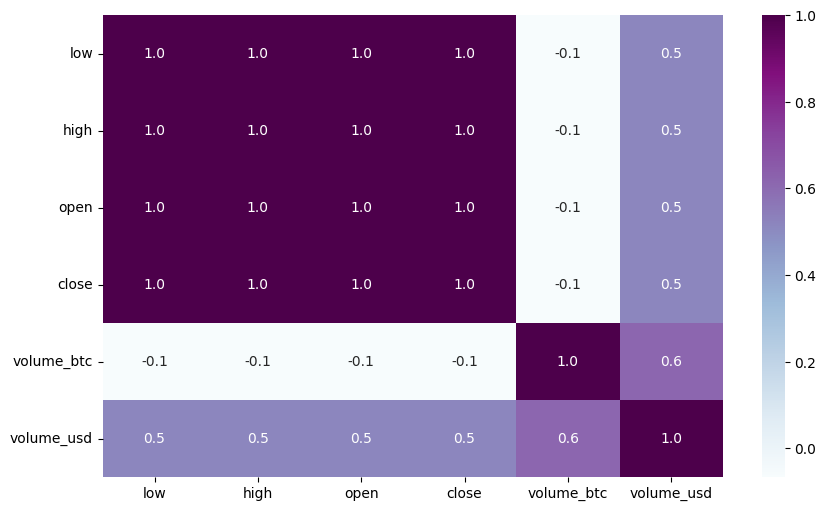

In [22]:
feature_selection(daily_df)

Here we can observe that, the high, low, open and close are the almost correlate features, so for price forecasting, we can drop all of them from the original dataset except for the closing price. Also we can drop volume_btc and volume_usd since we are not gonna use it. 

Selected Features
- Close Price

In [23]:
def dropping_columns(dataframe):
  dataframe = dataframe.drop("high") \
        .drop("low") \
        .drop("open") \
        .drop("volume_btc") \
        .drop("volume_usd")

  if SLOW_OPERATION:
    dataframe.printSchema()
    dataframe.show(5)

  return dataframe

In [24]:
df = dropping_columns(df)

root
 |-- date: timestamp (nullable = true)
 |-- close: double (nullable = true)

+-------------------+--------+
|               date|   close|
+-------------------+--------+
|2023-02-21 00:33:00|24859.34|
|2023-02-21 00:32:00|24859.34|
|2023-02-21 00:31:00|24821.96|
|2023-02-21 00:30:00|24818.09|
|2023-02-21 00:29:00|24812.25|
+-------------------+--------+
only showing top 5 rows



Saving the final dataset and moving it to the root folder

In [39]:
def output(dataframe):
  from pyspark.sql.functions import date_format, to_timestamp, col

  # transform date column into string
  dataframe = dataframe.withColumn("date", to_timestamp(col("date"), "yyyy-MM-dd HH:mm:ss").cast("string"))

  # save the dataset in CSV format
  dataframe.repartition(1).write.csv(GDRIVE_DATASET_TEMP_DIR, header=True, mode='overwrite')

  import os
  import glob
  import time

  while True:
      csv_files = glob.glob(os.path.join(GDRIVE_DATASET_TEMP_DIR, "part*.csv"))
      if len(csv_files) > 0:
          # .csv file found!
          file_path = csv_files[0]
          break
      else:
          print(".csv file not found. I'll try again after 1 second...")
          time.sleep(1)

  print(".csv file found:", file_path)

  new_file_path = GDRIVE_DATASET_OUTPUT_DIR + "/" + GDRIVE_DATASET_NAME + "_cleaned.csv"

  import shutil

  # Rinomina il file
  shutil.move(file_path, new_file_path)

  print("File renamed and moved successfully!")

In [40]:
output(df)

.csv file found: /content/drive/MyDrive/Computer_Science/BDC/project/datasets/temp/part-00000-80bd4e9a-532b-44f1-b89b-a359a0f76625-c000.csv
File renamed and moved successfully!
